In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from utils import *

# LOS Prediction

In [3]:

data = pd.read_csv('los_features.csv').drop('Unnamed: 0', axis=1)

data = pd.get_dummies(data, columns=['ADMISSION_TYPE', 'INSURANCE'])

data['y1'] = data['LOS'].apply(lambda x: 0 if x<3 else 1)
data['y2'] = data['LOS'].apply(lambda x: 0 if x<7 else 1)

rus = RandomUnderSampler(random_state=0)
y1 = data['y1']
X1 = data.drop(['LOS', 'y1', 'y2'], axis=1)
X1, y1 = rus.fit_resample(X1, y1)

rus2 = RandomUnderSampler(random_state=2)
y2 = data['y2']
X2 = data.drop(['LOS', 'y1', 'y2'], axis=1)
X2, y2 = rus2.fit_resample(X2, y2)

feature_names = X1.columns.values.tolist()
print(Counter(y1))
print(Counter(y2))

Counter({0: 8370, 1: 8370})
Counter({0: 24787, 1: 24787})


In [4]:
sc = preprocessing.StandardScaler()
mm = preprocessing.MinMaxScaler()
mm.fit(pd.concat([X1, X2]))
X1 = mm.transform(X1)
X2 = mm.transform(X2)

X2


array([[0.21353221, 0.96253897, 0.20640939, ..., 1.        , 0.        ,
        0.        ],
       [0.21353221, 0.96253897, 0.20640939, ..., 1.        , 0.        ,
        0.        ],
       [0.21353221, 0.96253897, 0.20640939, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.21353221, 0.96253897, 0.20640939, ..., 0.        , 1.        ,
        0.        ],
       [0.21353221, 0.96253897, 0.20640939, ..., 0.        , 1.        ,
        0.        ],
       [0.21353221, 0.96253897, 0.20640939, ..., 0.        , 1.        ,
        0.        ]])

In [6]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=27)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=27)

In [19]:
# Logistic Regression for Short Stay Prediction
lr = LogisticRegression(random_state=4)
lr.fit(X_train1, y_train1)

lr_score1 = lr.score(X_test1, y_test1)
lr_score2 = lr.score(X_train1, y_train1)

y_pred = lr.predict_proba(X_test1)[:, 1]
auroc = roc_auc_score(y_test1, y_pred)
print(lr_score1)
print(lr_score2)
print(auroc)

0.6971326164874552
0.7041517323775388
0.7614281839530054


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
# Logistic Regression for Long Stay Prediction
lr = LogisticRegression()
lr.fit(X_train2, y_train2)

lr_score1 = lr.score(X_test2, y_test2)
lr_score2 = lr.score(X_train2, y_train2)
y_pred = lr.predict_proba(X_test2)[:, 1]
auroc = roc_auc_score(y_test2, y_pred)
print(lr_score1)
print(lr_score2)
print(auroc)

0.6891578416540595
0.6933609016868807
0.7625502221323632


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 11383 samples, validate on 2009 samples
Epoch 1/150
11383/11383 [==============================] - 1s 70us/step - loss: 0.6804 - accuracy: 0.5675 - val_loss: 0.6208 - val_accuracy: 0.6521
Epoch 2/150
11383/11383 [==============================] - 0s 30us/step - loss: 0.6236 - accuracy: 0.6510 - val_loss: 0.5960 - val_accuracy: 0.6710
Epoch 3/150
11383/11383 [==============================] - 0s 27us/step - loss: 0.6067 - accuracy: 0.6667 - val_loss: 0.5741 - val_accuracy: 0.7023
Epoch 4/150
11383/11383 [==============================] - 0s 38us/step - loss: 0.5881 - accuracy: 0.6844 - val_loss: 0.5643 - val_accuracy: 0.7053
Epoch 5/150
11383/11383 [==============================] - 0s 37us/step - loss: 0.5846 - accuracy: 0.6912 - val_loss: 0.5582 - val_accuracy: 0.7138
Epoch 6/150
11383/11383 [==============================] - 0s 32us/step - loss: 0.5749 - accuracy: 0.6975 - val_loss: 0.5529 - val_accuracy: 0.7093
Epoch 7/150
11383/11383 [==============================] - 0s 3

Epoch 56/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.5009 - accuracy: 0.7499 - val_loss: 0.5226 - val_accuracy: 0.7432
Epoch 57/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.5013 - accuracy: 0.7476 - val_loss: 0.5374 - val_accuracy: 0.7282
Epoch 58/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.5021 - accuracy: 0.7518 - val_loss: 0.5201 - val_accuracy: 0.7461
Epoch 59/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.4929 - accuracy: 0.7547 - val_loss: 0.5212 - val_accuracy: 0.7446
Epoch 60/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4966 - accuracy: 0.7538 - val_loss: 0.5224 - val_accuracy: 0.7461
Epoch 61/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.4978 - accuracy: 0.7530 - val_loss: 0.5243 - val_accuracy: 0.7427
Epoch 62/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.4927 - accuracy: 0.7607

Epoch 111/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4645 - accuracy: 0.7760 - val_loss: 0.5247 - val_accuracy: 0.7437
Epoch 112/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4736 - accuracy: 0.7682 - val_loss: 0.5211 - val_accuracy: 0.7476
Epoch 113/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4700 - accuracy: 0.7766 - val_loss: 0.5254 - val_accuracy: 0.7456
Epoch 114/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.4678 - accuracy: 0.7752 - val_loss: 0.5232 - val_accuracy: 0.7437
Epoch 115/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4687 - accuracy: 0.7745 - val_loss: 0.5287 - val_accuracy: 0.7402
Epoch 116/150
11383/11383 [==============================] - 0s 23us/step - loss: 0.4653 - accuracy: 0.7777 - val_loss: 0.5256 - val_accuracy: 0.7451
Epoch 117/150
11383/11383 [==============================] - 0s 24us/step - loss: 0.4670 - accuracy:

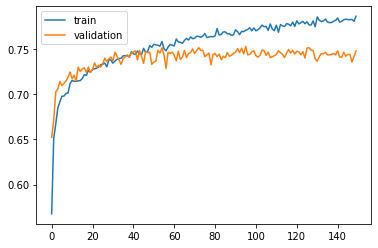

In [9]:
# Neural Network1


def nn(input_dim, output_dim=1, final_act='sigmoid', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation=final_act))

    
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

l_model_3 = nn(X_train1.shape[1])
training = l_model_3.fit(X_train1, y_train1, validation_split=0.15, epochs=150, batch_size=128)
nn_score = l_model_3.evaluate(X_test1, y_test1)
nn_score2 = l_model_3.evaluate(X_train1, y_train1)
print('Test set score: ', nn_score[1])
print('Training set score', nn_score2[1])
plt.plot(training.history['accuracy'], label='train')
plt.plot(training.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


AUROC:  0.8139784869487012


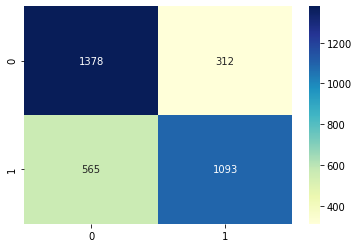

In [11]:
y_pred1 = l_model_3.predict(X_test1)
auroc = roc_auc_score(y_test1, y_pred1)
print("AUROC: ", auroc)
y_pred1 = np.round(y_pred1)
cm = confusion_matrix(y_test1, y_pred1)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");



Train on 33710 samples, validate on 5949 samples
Epoch 1/150
33710/33710 [==============================] - 1s 33us/step - loss: 0.6440 - accuracy: 0.6226 - val_loss: 0.5999 - val_accuracy: 0.6744
Epoch 2/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.6014 - accuracy: 0.6745 - val_loss: 0.5936 - val_accuracy: 0.6821
Epoch 3/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5886 - accuracy: 0.6878 - val_loss: 0.5866 - val_accuracy: 0.6917
Epoch 4/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5841 - accuracy: 0.6906 - val_loss: 0.5877 - val_accuracy: 0.6897
Epoch 5/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5829 - accuracy: 0.6891 - val_loss: 0.5824 - val_accuracy: 0.6941
Epoch 6/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5775 - accuracy: 0.6967 - val_loss: 0.5805 - val_accuracy: 0.6944
Epoch 7/150
33710/33710 [==============================] - 1s 2

Epoch 56/150
33710/33710 [==============================] - 1s 29us/step - loss: 0.5253 - accuracy: 0.7347 - val_loss: 0.5456 - val_accuracy: 0.7139
Epoch 57/150
33710/33710 [==============================] - 1s 29us/step - loss: 0.5235 - accuracy: 0.7344 - val_loss: 0.5398 - val_accuracy: 0.7237
Epoch 58/150
33710/33710 [==============================] - 1s 26us/step - loss: 0.5239 - accuracy: 0.7372 - val_loss: 0.5395 - val_accuracy: 0.7220
Epoch 59/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5236 - accuracy: 0.7373 - val_loss: 0.5423 - val_accuracy: 0.7248
Epoch 60/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5217 - accuracy: 0.7388 - val_loss: 0.5387 - val_accuracy: 0.7205
Epoch 61/150
33710/33710 [==============================] - 1s 24us/step - loss: 0.5222 - accuracy: 0.7390 - val_loss: 0.5396 - val_accuracy: 0.7225
Epoch 62/150
33710/33710 [==============================] - 1s 26us/step - loss: 0.5211 - accuracy: 0.7374

33710/33710 [==============================] - 1s 36us/step - loss: 0.5059 - accuracy: 0.7490 - val_loss: 0.5374 - val_accuracy: 0.7279
Epoch 111/150
33710/33710 [==============================] - 1s 33us/step - loss: 0.5050 - accuracy: 0.7492 - val_loss: 0.5381 - val_accuracy: 0.7265
Epoch 112/150
33710/33710 [==============================] - 1s 31us/step - loss: 0.5044 - accuracy: 0.7506 - val_loss: 0.5393 - val_accuracy: 0.7279
Epoch 113/150
33710/33710 [==============================] - 1s 28us/step - loss: 0.5068 - accuracy: 0.7487 - val_loss: 0.5373 - val_accuracy: 0.7257
Epoch 114/150
33710/33710 [==============================] - 1s 28us/step - loss: 0.5058 - accuracy: 0.7474 - val_loss: 0.5384 - val_accuracy: 0.7237
Epoch 115/150
33710/33710 [==============================] - 1s 27us/step - loss: 0.5042 - accuracy: 0.7492 - val_loss: 0.5363 - val_accuracy: 0.7265
Epoch 116/150
33710/33710 [==============================] - 1s 29us/step - loss: 0.5050 - accuracy: 0.7486 - val_

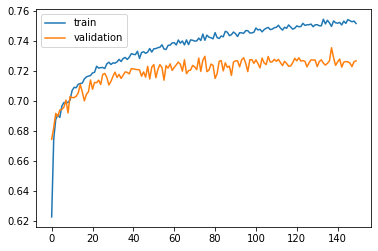

In [15]:
l_model_7 = nn(X_train2.shape[1])
training = l_model_7.fit(X_train2, y_train2, validation_split=0.15, epochs=150, batch_size=128)
nn_score = l_model_7.evaluate(X_test2, y_test2)
nn_score2 = l_model_7.evaluate(X_train2, y_train2)
print('Test set score: ', nn_score[1])
print('Training set score', nn_score2[1])
plt.plot(training.history['accuracy'], label='train')
plt.plot(training.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


AUROC:  0.8096783651005973


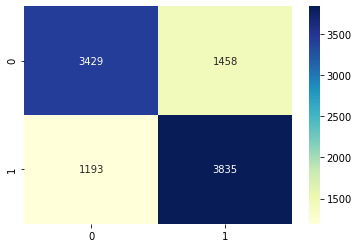

In [16]:
y_pred2 = l_model_7.predict(X_test2)
auroc = roc_auc_score(y_test2, y_pred2)
print("AUROC: ", auroc)

y_pred2 = np.round(y_pred2)


cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");


In [17]:
def assign_label(x):
    if x<3:
        return 0
    elif x<7:
        return 1
    else:
        return 2
td = data.drop(['y1', 'y2'], axis=1)
ty = td['LOS'].apply(lambda x: assign_label(x))
result_y = np.ones(ty.shape)
tx = td.drop('LOS', axis=1)
tx = mm.transform(tx)
py = np.round(l_model_3.predict(tx)).flatten()
py2 = np.round(l_model_7.predict(tx)).flatten()
idx0 = np.where(py==0)
idx2 = np.where(py2==1)
np.put(result_y, idx0, 0)
np.put(result_y, idx2, 2)

accuracy = accuracy_score(ty, result_y)
print(accuracy)

0.5907989837918742


# Mortality

In [20]:
data = pd.read_csv('m_features.csv').drop('Unnamed: 0', axis=1)
data = pd.get_dummies(data, columns=['ADMISSION_TYPE', 'INSURANCE'])

label_0 = data[data['HOSPITAL_EXPIRE_FLAG']==0]
label_1 = data[data['HOSPITAL_EXPIRE_FLAG']==1]

base_num = min(len(label_0), len(label_1))
label_0 = label_0.sample(n=base_num, random_state=2)
data = pd.concat([label_0, label_1])

y = data['HOSPITAL_EXPIRE_FLAG'].to_numpy()
X = data.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1)

feature_names=list(X)

y

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
Counter(y)

Counter({0: 5715, 1: 5715})

In [22]:
mm2 = preprocessing.MinMaxScaler()
mm2.fit(X)
X = mm2.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
# LogisticRegression for Mortality Prediction
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_score1 = lr.score(X_test, y_test)
lr_score2 = lr.score(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)
print(lr_score1)
print(lr_score2)
print(auroc)

0.7572178477690289
0.756233595800525
0.8382596235263466


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train on 7772 samples, validate on 1372 samples
Epoch 1/150
7772/7772 [==============================] - 1s 78us/step - loss: 0.6824 - accuracy: 0.5786 - val_loss: 0.5898 - val_accuracy: 0.7201
Epoch 2/150
7772/7772 [==============================] - 0s 34us/step - loss: 0.5870 - accuracy: 0.6907 - val_loss: 0.5355 - val_accuracy: 0.7398
Epoch 3/150
7772/7772 [==============================] - 0s 33us/step - loss: 0.5436 - accuracy: 0.7256 - val_loss: 0.5105 - val_accuracy: 0.7544
Epoch 4/150
7772/7772 [==============================] - 0s 32us/step - loss: 0.5290 - accuracy: 0.7405 - val_loss: 0.5010 - val_accuracy: 0.7580
Epoch 5/150
7772/7772 [==============================] - 0s 32us/step - loss: 0.5159 - accuracy: 0.7396 - val_loss: 0.4949 - val_accuracy: 0.7551
Epoch 6/150
7772/7772 [==============================] - 0s 32us/step - loss: 0.5088 - accuracy: 0.7455 - val_loss: 0.4902 - val_accuracy: 0.7617
Epoch 7/150
7772/7772 [==============================] - 0s 32us/step - loss

7772/7772 [==============================] - 0s 37us/step - loss: 0.4042 - accuracy: 0.8129 - val_loss: 0.4380 - val_accuracy: 0.7952
Epoch 57/150
7772/7772 [==============================] - 0s 31us/step - loss: 0.4021 - accuracy: 0.8168 - val_loss: 0.4409 - val_accuracy: 0.7959
Epoch 58/150
7772/7772 [==============================] - 0s 32us/step - loss: 0.4027 - accuracy: 0.8139 - val_loss: 0.4429 - val_accuracy: 0.7930
Epoch 59/150
7772/7772 [==============================] - 0s 30us/step - loss: 0.4096 - accuracy: 0.8097 - val_loss: 0.4471 - val_accuracy: 0.7908
Epoch 60/150
7772/7772 [==============================] - 0s 31us/step - loss: 0.4057 - accuracy: 0.8146 - val_loss: 0.4418 - val_accuracy: 0.7974
Epoch 61/150
7772/7772 [==============================] - 0s 30us/step - loss: 0.4001 - accuracy: 0.8185 - val_loss: 0.4413 - val_accuracy: 0.7937
Epoch 62/150
7772/7772 [==============================] - 0s 31us/step - loss: 0.4006 - accuracy: 0.8141 - val_loss: 0.4380 - val_a

Epoch 112/150
7772/7772 [==============================] - 0s 41us/step - loss: 0.3632 - accuracy: 0.8396 - val_loss: 0.4573 - val_accuracy: 0.7886
Epoch 113/150
7772/7772 [==============================] - 0s 34us/step - loss: 0.3639 - accuracy: 0.8388 - val_loss: 0.4605 - val_accuracy: 0.7937
Epoch 114/150
7772/7772 [==============================] - 0s 33us/step - loss: 0.3627 - accuracy: 0.8359 - val_loss: 0.4560 - val_accuracy: 0.7886
Epoch 115/150
7772/7772 [==============================] - 0s 34us/step - loss: 0.3607 - accuracy: 0.8390 - val_loss: 0.4527 - val_accuracy: 0.7857
Epoch 116/150
7772/7772 [==============================] - 0s 32us/step - loss: 0.3561 - accuracy: 0.8372 - val_loss: 0.4616 - val_accuracy: 0.7886
Epoch 117/150
7772/7772 [==============================] - 0s 30us/step - loss: 0.3558 - accuracy: 0.8412 - val_loss: 0.4610 - val_accuracy: 0.7828
Epoch 118/150
7772/7772 [==============================] - 0s 43us/step - loss: 0.3587 - accuracy: 0.8402 - val_

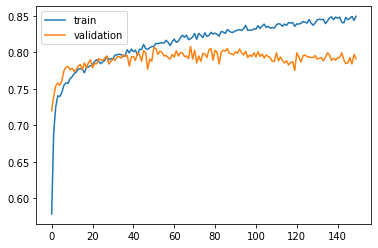

In [24]:
# Neural Network
m_model = Sequential()
m_model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
m_model.add(Dropout(0.2))
m_model.add(Dense(128, activation='sigmoid'))
m_model.add(Dropout(0.2))
m_model.add(Dense(1, activation='sigmoid'))

m_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn = m_model.fit(X_train, y_train, validation_split=0.15, epochs=150, batch_size=100)
nn_score = m_model.evaluate(X_test, y_test)
nn_score2 = m_model.evaluate(X_train, y_train)
print(nn_score[1])
print(nn_score2[1])
plt.plot(nn.history['accuracy'], label='train')
plt.plot(nn.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


AUROC:  0.860433868069471


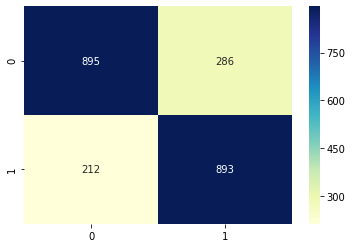

In [25]:

y_true = y_test
y_scores = m_model.predict_proba(X_test)
y_pred = m_model.predict(X_test)


y_pred = np.round(y_pred)
y_pred = y_pred.flatten()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu");
auroc = roc_auc_score(y_true, y_scores)
print("AUROC: ", auroc)